In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def generate_paths_vectorized(vol_params, stock_params, num_steps, num_paths):
    kappa, theta, sigma, rho, v0 = vol_params
    S0, mu, T = stock_params
    dt = T / num_steps
    sqrt_dt = np.sqrt(dt)

    # Preallocate
    S = np.full(num_paths, S0)
    v = np.full(num_paths, v0)

    S_paths = np.zeros((num_steps + 1, num_paths))
    v_paths = np.zeros((num_steps + 1, num_paths))

    S_paths[0] = S
    v_paths[0] = v

    # Correlation matrix
    corr = np.array([[1.0, rho], [rho, 1.0]])
    L = np.linalg.cholesky(corr)

    for t in range(1, num_steps + 1):
        # Generate correlated normals for all paths at once
        Z = np.random.normal(size=(2, num_paths))
        Z = L @ Z
        z1, z2 = Z

        v_pos = np.maximum(v, 0.0)

        # Vectorized variance update
        v = v + kappa * (theta - v_pos) * dt + sigma * np.sqrt(v_pos) * sqrt_dt * z1
        v = np.maximum(v, 0.0)

        # Vectorized stock update
        S = S + mu * S * dt + S * np.sqrt(v_pos) * sqrt_dt * z2

        S_paths[t] = S
        v_paths[t] = v

    return S_paths.T, v_paths.T

In [3]:
vol_params = (10.0, 0.05, 0.3, -0.8, 0.01)
stock_params = (100, 0.15, 1)

S, v = generate_paths_vectorized(vol_params, stock_params, 200, 1000)

In [4]:
def generate_features(S, v):
    returns = np.log(S[:,1:] / S[:,:-1])
    abs_returns = np.abs(returns)
    square_returns = returns ** 2
    v_shift = v[:, :-1]

    return np.stack([returns, abs_returns, square_returns, v_shift], axis=2)

In [5]:
X = generate_features(S, v)

y = (v[:, 1:] > v[:, :-1]).astype(int)

print(X.shape)
print(y.shape)

(1000, 200, 4)
(1000, 200)


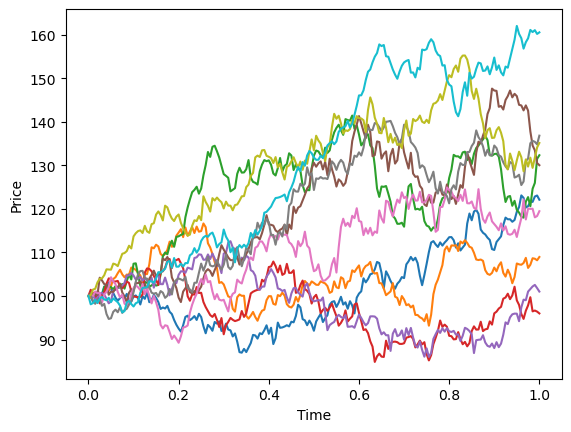

In [20]:
time = np.arange(201) / 200
for i in range(10):
    plt.plot(time, S[i])

plt.xlabel('Time')
plt.ylabel('Price')

plt.show()

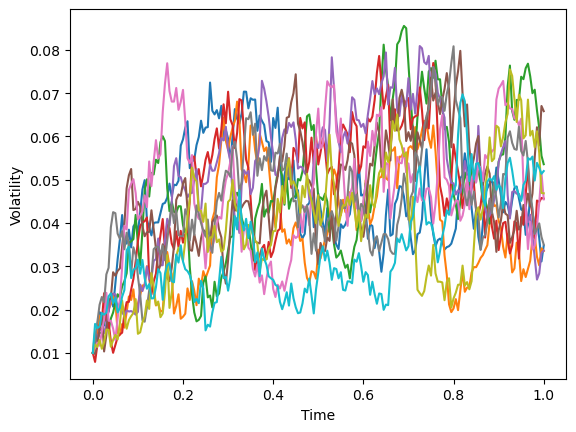

In [22]:
for i in range(10):
    plt.plot(time, v[i])

plt.xlabel('Time')
plt.ylabel('Volatility')

plt.show()

In [352]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle=False)

In [353]:
def make_sequences(data, labels, seq_len):
    N, T, _ = data.shape

    X_list = []
    y_list = []

    for p in range(N):
        for t in range(T - seq_len):
            X_list.append(data[p, t : t + seq_len])
            y_list.append(labels[p, t + seq_len])
    X = np.array(X_list)
    y = np.array(y_list)

    return X, y

In [354]:
X_train_seq, y_train_seq = make_sequences(X_train, y_train, 100) # sequence length 100
X_test_seq, y_test_seq = make_sequences(X_test, y_test, 100)

# rows = observed sequences
# columns = entries in sequence
# third axis = features
print(X_train_seq.shape, y_train_seq.shape)

(80000, 100, 4) (80000,)


In [355]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_2d = X_train_seq.reshape(-1, X_train.shape[-1])  # flatten time dimension
X_test_2d = X_test_seq.reshape(-1, X_test.shape[-1])

X_train_scaled = scaler.fit_transform(X_train_2d).reshape(X_train_seq.shape)
X_test_scaled = scaler.transform(X_test_2d).reshape(X_test_seq.shape)

In [356]:
# flat pack tensors
xtrain_flat = X_train_scaled.reshape(80000, 400)
xtest_flat = X_test_scaled.reshape(20000, 400)

pd.DataFrame(xtrain_flat).to_csv('X_train.csv', index=None, columns=None)
pd.DataFrame(xtest_flat).to_csv('X_test.csv', index=None, columns=None)

pd.DataFrame(y_train_seq).to_csv('y_train.csv', index=None, columns=None)
pd.DataFrame(y_test_seq).to_csv('y_test.csv', index=None, columns=None)